## Code for loading data and creating the data-acquisition model

Text(0.5, 1.0, 'ground-truth')

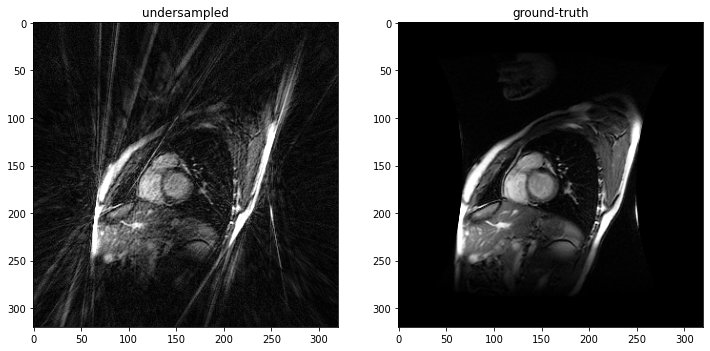

In [1]:
import torch
import torch.nn as nn

from networks.encoding_object import Dyn2DRadEncObj
from networks.caol_network import ConvAnaOpLearningCNN

from utils.noise_funcs import add_gaussian_noise
from utils.cplx_helper_funcs import cplx_np2torch, cplx_torch2np
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#datatype
dtype = torch.float

#whether to use the gpu or not;
use_GPU=1

#load data
xf = np.load('toy_data/img_320.npy')
ktraj = np.load('toy_data/ktraj_320.npy') 
csm = np.load('toy_data/csmap_320.npy')
dcomp = np.load('toy_data/dcomp_320.npy')  #shape (Nrad,20)

#convert to tensors
xf_tensor = cplx_np2torch(xf,0).unsqueeze(0).unsqueeze(0) # (1,1,2,320,320,20)
ktraj_tensor = cplx_np2torch(ktraj,0).unsqueeze(0) # (1,2,11520,20)
csm_tensor = cplx_np2torch(csm,1).unsqueeze(0) #(1,12,2,320, 320)
dcomp_tensor = torch.tensor(dcomp).unsqueeze(0).unsqueeze(0).unsqueeze(0) 

#create encoding operator object
im_size = xf.shape

if use_GPU:
	xf_tensor = xf_tensor.to('cuda')
	ktraj_tensor = ktraj_tensor.to('cuda')
	csm_tensor = csm_tensor.to('cuda')
	dcomp_tensor = dcomp_tensor.to('cuda')
	
	EncObj = Dyn2DRadEncObj(im_size,ktraj_tensor,dcomp_tensor,csm_tensor,norm='ortho').cuda()
else:
	EncObj = Dyn2DRadEncObj(im_size,ktraj_tensor,dcomp_tensor,csm_tensor,norm='ortho')
	
with torch.no_grad():
	#generate k-sace data, add noise
	ku_tensor = EncObj.apply_A(xf_tensor)
	ku_tensor = add_gaussian_noise(ku_tensor,sigma=0.02)
	
	#get initial reconstruction
	xu_tensor = EncObj.apply_Adag(ku_tensor)

xu = cplx_torch2np(xu_tensor.squeeze(0).squeeze(0).detach().cpu(),0)

#create figure
fig,ax = plt.subplots(1,2,figsize=(6*2,6))
ax[0].imshow(np.abs(xu)[...,1],cmap=plt.cm.Greys_r,clim=[0,1000])
ax[1].imshow(np.abs(xf)[...,1],cmap=plt.cm.Greys_r,clim=[0,1000])
ax[0].set_title('undersampled')
ax[1].set_title('ground-truth')